# Exploring the SVHN Data

### Importing neccessary libraries

In [1]:

from typing import List

import os

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# On Windows:
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


### Loading the test and training data

In [2]:
train = torchvision.datasets.SVHN(root="data/", split="train", transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.SVHN(root="data/", split="test", transform=torchvision.transforms.ToTensor())

### Preparing out data set

In [3]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = DataLoader(train, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 3, 32, 32])

In [4]:
class Net(nn.Module):
    def __init__(self, stride: int = 1, padding: int = 0, dilation: int = 1):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=stride, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding=padding)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [5]:
def train(network: Net, optimizer, epoch: int, train_losses: List, train_counter: List):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [6]:
def test(network: Net, test_losses: List):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [7]:
network_zero_padding = Net()
zero_pad_optimizer = optim.SGD(network_zero_padding.parameters(), lr=learning_rate,
                      momentum=momentum)

In [8]:
train_losses_zero_padding = []
train_counter_zero_padding = []
test_losses_zero_padding = []
test_counter_zero_padding = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [9]:
print(example_data.shape)
test(network_zero_padding, test_losses_zero_padding)
for epoch in range(1, n_epochs + 1):
  train(network_zero_padding, zero_pad_optimizer, 
        epoch, train_losses_zero_padding, train_counter_zero_padding)
  test(network_zero_padding, test_losses_zero_padding)

torch.Size([1000, 3, 32, 32])


C:\Users\nawor\AppData\Local\Temp\ipykernel_10080\763589605.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\Users\nawor\miniconda3\envs\cs178\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3034, Accuracy: 1977/26032 (8%)

Train Epoch: 1 [0/73257 (0%)]	Loss: 2.305881
Train Epoch: 1 [640/73257 (1%)]	Loss: 2.301186
Train Epoch: 1 [1280/73257 (2%)]	Loss: 2.298079
Train Epoch: 1 [1920/73257 (3%)]	Loss: 2.301338
Train Epoch: 1 [2560/73257 (3%)]	Loss: 2.298445
Train Epoch: 1 [3200/73257 (4%)]	Loss: 2.284375
Train Epoch: 1 [3840/73257 (5%)]	Loss: 2.279866
Train Epoch: 1 [4480/73257 (6%)]	Loss: 2.283828
Train Epoch: 1 [5120/73257 (7%)]	Loss: 2.273942
Train Epoch: 1 [5760/73257 (8%)]	Loss: 2.279344
Train Epoch: 1 [6400/73257 (9%)]	Loss: 2.286662
Train Epoch: 1 [7040/73257 (10%)]	Loss: 2.270423
Train Epoch: 1 [7680/73257 (10%)]	Loss: 2.287980
Train Epoch: 1 [8320/73257 (11%)]	Loss: 2.241739
Train Epoch: 1 [8960/73257 (12%)]	Loss: 2.272864
Train Epoch: 1 [9600/73257 (13%)]	Loss: 2.282553
Train Epoch: 1 [10240/73257 (14%)]	Loss: 2.262758
Train Epoch: 1 [10880/73257 (15%)]	Loss: 2.229692
Train Epoch: 1 [11520/73257 (16%)]	Loss: 2.190415
Train Epoch: 1 [12160/73

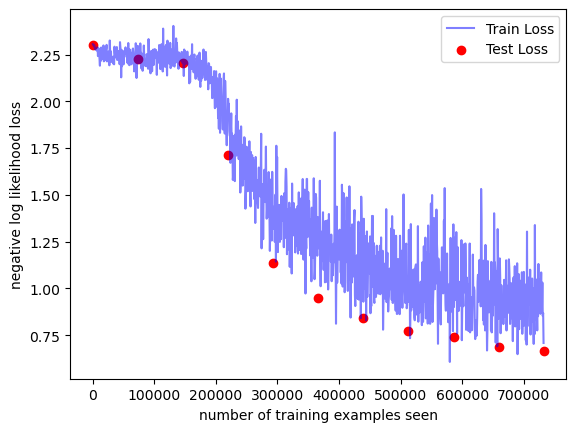

In [10]:
fig = plt.figure()
plt.plot(train_counter_zero_padding, train_losses_zero_padding, color='blue', alpha=.5)
plt.scatter(test_counter_zero_padding, test_losses_zero_padding, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig
plt.show()

In [11]:
with torch.no_grad():
  output_zero_padding = network_zero_padding(example_data)

C:\Users\nawor\AppData\Local\Temp\ipykernel_10080\763589605.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


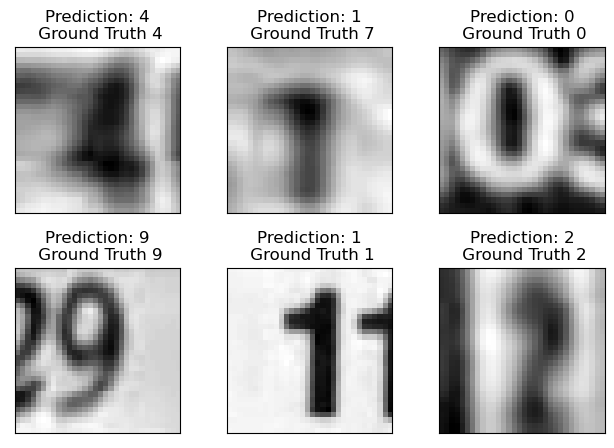

In [12]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  pred = output_zero_padding.data.max(1, keepdim=True)[1][i].item()
  plt.title("Prediction: {}\n Ground Truth {}".format(pred, example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()

In [13]:
network_padded = Net()
zero_pad_optimizer = optim.SGD(network_padded.parameters(), lr=learning_rate,
                      momentum=momentum)

In [14]:

train_losses_padded = []
train_counter_padded = []
test_losses_padded = []
test_counter_padded = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [15]:

print(example_data.shape)
test(network_padded, test_losses_padded)
for epoch in range(1, n_epochs + 1):
  train(network_padded, zero_pad_optimizer, 
        epoch, train_losses_padded, train_counter_padded)
  test(network_padded, test_losses_padded)


torch.Size([1000, 3, 32, 32])


C:\Users\nawor\AppData\Local\Temp\ipykernel_10080\763589605.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3023, Accuracy: 3305/26032 (13%)

Train Epoch: 1 [0/73257 (0%)]	Loss: 2.284405
Train Epoch: 1 [640/73257 (1%)]	Loss: 2.289718
Train Epoch: 1 [1280/73257 (2%)]	Loss: 2.289563
Train Epoch: 1 [1920/73257 (3%)]	Loss: 2.302721
Train Epoch: 1 [2560/73257 (3%)]	Loss: 2.274057
Train Epoch: 1 [3200/73257 (4%)]	Loss: 2.282709
Train Epoch: 1 [3840/73257 (5%)]	Loss: 2.299018
Train Epoch: 1 [4480/73257 (6%)]	Loss: 2.260036
Train Epoch: 1 [5120/73257 (7%)]	Loss: 2.271899
Train Epoch: 1 [5760/73257 (8%)]	Loss: 2.316326
Train Epoch: 1 [6400/73257 (9%)]	Loss: 2.271348
Train Epoch: 1 [7040/73257 (10%)]	Loss: 2.254614
Train Epoch: 1 [7680/73257 (10%)]	Loss: 2.287509
Train Epoch: 1 [8320/73257 (11%)]	Loss: 2.219128
Train Epoch: 1 [8960/73257 (12%)]	Loss: 2.229755
Train Epoch: 1 [9600/73257 (13%)]	Loss: 2.264931
Train Epoch: 1 [10240/73257 (14%)]	Loss: 2.242351
Train Epoch: 1 [10880/73257 (15%)]	Loss: 2.250530
Train Epoch: 1 [11520/73257 (16%)]	Loss: 2.338862
Train Epoch: 1 [12160/7

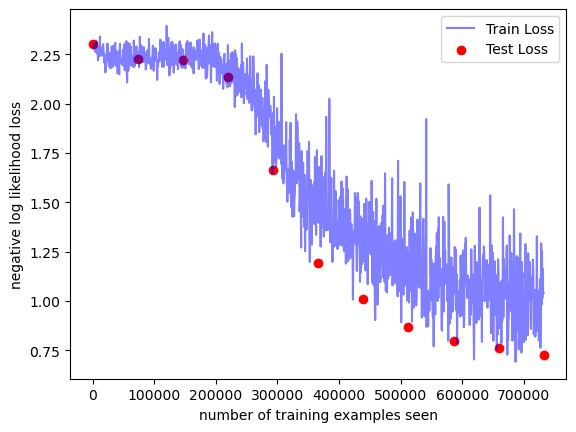

In [16]:

fig = plt.figure()
plt.plot(train_counter_padded, train_losses_padded, color='blue', alpha=.5)
plt.scatter(test_counter_padded, test_losses_padded, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig
plt.show()


In [17]:

with torch.no_grad():
  output_padded = network_padded(example_data)


C:\Users\nawor\AppData\Local\Temp\ipykernel_10080\763589605.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


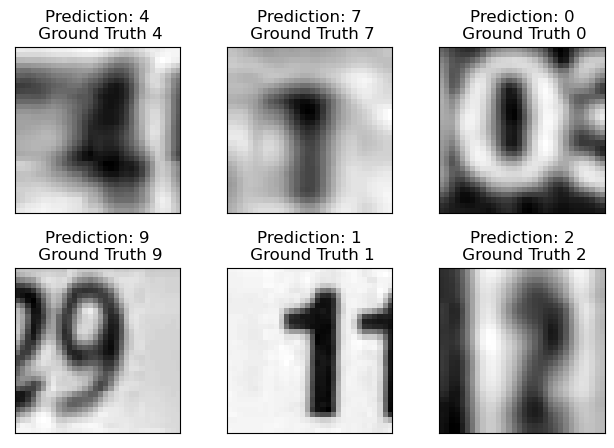

In [18]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  pred = output_padded.data.max(1, keepdim=True)[1][i].item()
  plt.title("Prediction: {}\n Ground Truth {}".format(pred, example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()

### Padding vs no Padding

Padding resulted in lower accuracy and higher average loss. This is likely because padding ensures that the entire image is seen by the kernel window. However, since in this dataset there is "noise" from numbers other than the target number on the edges of the image, the edges are better off ignored.